<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Ames Housing Data and Kaggle Challenge

---

### Contents:
- [Background](#Background)
- [Problem Statement](#Problem-Statement)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Dummify Who?](#Dummify-who?)
- [Remove Outliers](#Remove-Outliers)
- [Baseline Simple Model](#Baseline-Simple-Model)
- [Make a Working Model](#Make-a-Working-Model)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Background

The Iowa State University and the Commerce Committee of the Iowa House of Representatives are looking into the community of Ames Iowa to understand home values in our region. The Real Estate Appraisers Coalition of Ames Iowa and I have taken on the task of creating a simplified model that will predict home values based of multiple qualities of the home. We will be looking at everything from the numbers of bedrooms and baths, locationality, quality and condition, squarefootage, and materials.

We have a data set containing information from the Ames Assessor’s Office used in calculating the assessed values for individual residential properties sold in Ames, IA from 2006 to 2010. The detailed decription in the data documentaion is  here: ([DataDoc](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt))


We will be sorting through the eighty-two variables and identifying the most effect variables to include in our model. Then we will create our model and measure it's accuracy. 

## Problem Statement

         I am a data scientist working for the Real Estate Apraisers Coalition of Ames Iowa. We have a lot of homes in the region that need to be quickly apraised for goverment and educational purposes.          
         We have data from the Ames Iowa Assessor’s Office used in computing  values for individual residential properties sold in Ames, IA from 2006 to 2010. 
         We are going to create a model that predicts prices off home assesment data entries, and in doing so we will determine what factors make the most significant impacts on the model to make the model more effective.
         Furthermore we will test and verify these results on a national data base (Keggle) and come to an anysis on how effective the model actually is. 
         
Essentially we are asking the questions:
1. How much is a house worth?
2. What factors really matter in determining a fair market value?

## Data Import and Cleaning

1. Importing the tools I will use. 
2. Reading in the data and cleaning out the null values. 
3. Converting the ordinal values into a numerical ordered columns. 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier

In [2]:
iowatrain = pd.read_csv('./datasets/train.csv')
#Here we are reading the training set of data in

In [3]:
iowatrain.head(5)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
iowatrain.isnull().sum()

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    330
               ... 
Misc Val          0
Mo Sold           0
Yr Sold           0
Sale Type         0
SalePrice         0
Length: 81, dtype: int64

In [5]:
iowatrain.describe().T;

In [6]:
iowatrain.info()
# We have quite a few null values in columns Lot Frontage, Alley, 
# basements (all of them) and fence, etc... Lotta cleaning to be done. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [7]:
iowatrain.drop('Id', axis = 1, inplace=True) 
#Don't need this. We already have PID

https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
This is a link that showed me how to get my heatmap bigger.
Important to note that the heat map only shows corrrelations 
with numerical columns. 
I will use Dummify and I also need to make sure to remove outliners from ones I want

In [8]:
# fig, ax = plt.subplots(figsize=(10,10))  # Sample figsize in inches

# sns.heatmap(iowatrain.corr()[['SalePrice']].sort_values(
#                                                         by='SalePrice', 
#                                                         ascending=False),
#             annot=True, vmin=-1, vmax=1,
#            cmap='coolwarm', ax=ax);


In [9]:
iowatrain["Bsmt Cond"].fillna('NA', inplace=True)
iowatrain['Bsmt Qual'].fillna('NA', inplace=True)
iowatrain['Bsmt Exposure'].fillna('NA', inplace=True)
iowatrain['BsmtFin Type 1'].fillna('NA', inplace=True)
iowatrain['BsmtFin Type 2'].fillna('NA', inplace=True)

iowatrain['Fireplace Qu'].fillna('NA', inplace=True)
iowatrain['Garage Finish'].fillna('NA', inplace=True)
iowatrain['Garage Qual'].fillna('NA', inplace=True)
iowatrain['Garage Cond'].fillna('NA', inplace=True)
iowatrain['Pool QC'].fillna('NA', inplace=True)
iowatrain['Fence'].fillna('NA', inplace=True)

# Here I am cleaning the data so that all the columns that have the option of 
# having NA (not applicable) have all their null values as such. 

In [10]:
# How about we take all the ordinal variables and make them ranked! 
ordinalcols = [ 'Lot Shape', 'Utilities' , 'Land Slope', 'Exter Qual',
               'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 
               'BsmtFin Type 1', 'BsmtFin Type 2' , 'Heating QC',
               'Electrical', 'Kitchen Qual' , "Functional", 
               'Fireplace Qu', 'Garage Finish','Garage Qual', 
               'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence' ]
# ordinal_df = iowatrain[ordinalcols]

# ordinal_df.columns = [x.lower() for x in ordinal_df.columns]
# ordinal_df.columns = [x.strip().replace(' ', '_') for x in ordinal_df.columns]
iowatrain.columns = [x.lower() for x in iowatrain.columns]
iowatrain.columns = [x.strip().replace(' ', '_') for x in iowatrain.columns]
ordinalcols = [x.lower() for x in ordinalcols]
ordinalcols = [x.strip().replace(' ', '_') for x in ordinalcols]

In [11]:
iowatrain.replace({
            'lot_shape': {'Reg':4 , 'IR1':3 , 'IR2':2 , 'IR3':1 },
            'utilities': {'AllPub':3, 'NoSeWa':2, 'NoSewr':1 },
            'land_slope': {'Gtl':3,  'Mod':2, 'Sev':1},
            'exter_qual': {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'exter_cond': {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'bsmt_qual':  {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'bsmt_cond':  {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'bsmt_exposure': {'NA': 0, 'Gd':4 , 'Av':3, 'Mn':2, 'No':1},
            'bsmtfin_type_1': {'NA':0, 'GLQ':6, 'ALQ':5, 'BLQ':4,
                                      'Rec':3, 'LwQ':2, 'Unf':1},
            'bsmtfin_type_2': {'NA':0, 'GLQ':6, 'ALQ':5, 'BLQ':4,
                                      'Rec':3, 'LwQ':2, 'Unf':1},
            'heating_qc': {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'electrical': {'SBrkr':5, 'FuseA':4, 'FuseF':3, 'FuseP':2, 'Mix':1},
            'kitchen_qual':  {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'functional':{'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5, 
                                   'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':1 },
            'fireplace_qu': {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'garage_finish': {'NA':0, 'Fin':3, 'RFn':2, 'Unf':1},
            'garage_qual':   {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'garage_cond':    {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'paved_drive':   {'Y':3, 'P':2, 'N':1},
            'pool_qc':   {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'fence':  {'NA':0, 'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1}
            }, inplace=True)
#Okay The ordinal Values are now fixed and numbered!!!

In [12]:
iowatrain['alley'].fillna('NA', inplace=True)
iowatrain['mas_vnr_type'].fillna('NA', inplace=True)
iowatrain['garage_type'].fillna('NA', inplace=True)
iowatrain['misc_feature'].fillna('NA', inplace=True)
 #These are nominal values

In [13]:
# HERE THERE IS ONLY ONE NULL VALUE FOR THESE, SO I'M USING THE MEAN SO NOT TO SQEW
# THE DATA.
iowatrain['garage_yr_blt'].fillna(iowatrain['garage_yr_blt'].mean(), inplace=True)
iowatrain['bsmtfin_sf_1'].fillna(iowatrain['bsmtfin_sf_1'].mean(), inplace=True)
iowatrain['bsmtfin_sf_2'].fillna(iowatrain['bsmtfin_sf_2'].mean(), inplace=True)
iowatrain['mas_vnr_area'].fillna(iowatrain['mas_vnr_area'].mean(), inplace=True)
iowatrain['bsmt_unf_sf'].fillna(iowatrain['bsmt_unf_sf'].mean(), inplace=True)
iowatrain['total_bsmt_sf'].fillna(iowatrain['total_bsmt_sf'].mean(), inplace=True)
iowatrain['bsmt_full_bath'].fillna(iowatrain['bsmt_full_bath'].mean(), inplace=True)
iowatrain['bsmt_half_bath'].fillna(iowatrain['bsmt_half_bath'].mean(), inplace=True)
iowatrain['garage_cars'].fillna(iowatrain['garage_cars'].mean(), inplace=True)
iowatrain['garage_area'].fillna(iowatrain['garage_area'].mean(), inplace=True)
# I don't know why there are no 0 values for lot_frontage, so I'm going to 
# assume that they have no lottage by a street. 


In [14]:
# numericalcols = [col for col in iowatrain.columns if iowatrain[col].dtype != 'O']
#These are all the columsn that have numerical values. Now includind the
# Ordinal and Continuous and Discrete numerically.

In [15]:
iowatrain['lot_frontage'].corr(iowatrain['saleprice'])

0.3418424837268713

In [16]:
iowatrain['lot_frontage'].fillna(0).corr(
    iowatrain['saleprice'])

0.18145625081922262

In [17]:
iowatrain['lot_frontage'].fillna(
    iowatrain['lot_frontage'].mean(),inplace=True)
iowatrain['lot_frontage'].corr(iowatrain['saleprice'])
# Going with changing the nulls to be the mean in this situation. 
# I detail why in the readme attached. 

0.3258495122666743

In [18]:
iowatrain.columns

Index(['pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config',
       'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod/add', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air',
       'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual',
       'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu',
       'garage_type', 'garage_yr_blt', 'garage_finish'

## Exploratory Data Analysis


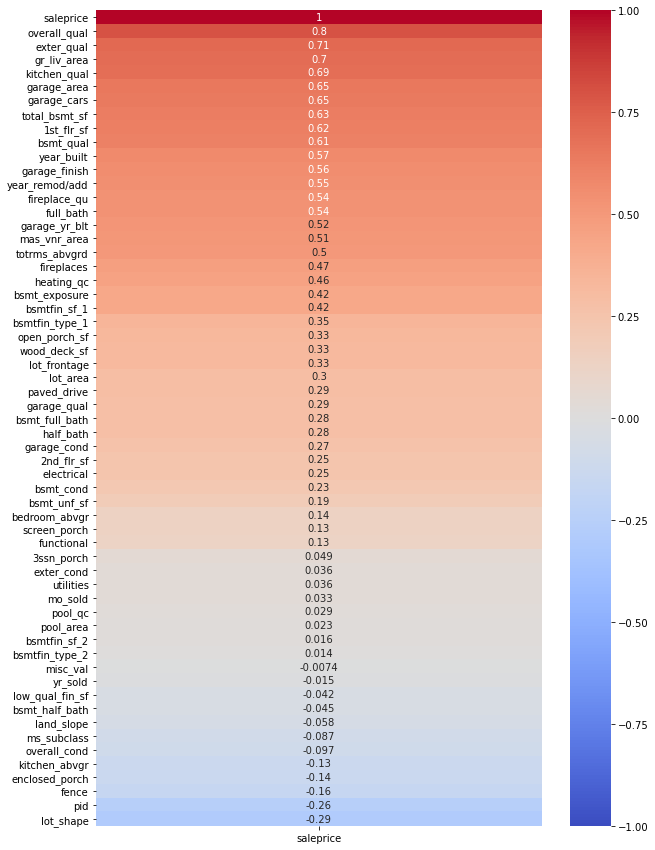

In [19]:
fig, ax = plt.subplots(figsize=(10,15))

sns.heatmap(iowatrain.corr()[['saleprice']].sort_values(by='saleprice', ascending=False),
            annot=True, vmin=-1, vmax=1,
           cmap='coolwarm', ax=ax);
# These indicate our initial Numerical columns correlation to price. 
# The stronger coorelated the more they impact price. 

    Okay let's dumify a few things and also lets bucket together a few things that relate so  some columns can be simplified and quantified numerically. 

    I've decided to bin together Neighborhoods into 3 classes (Great, No Influence, Bad) for if the coorelation is greater than or positive or negative 5%. 


In [20]:
iowatrain['ms_subclass'] = iowatrain['ms_subclass'].astype(str)

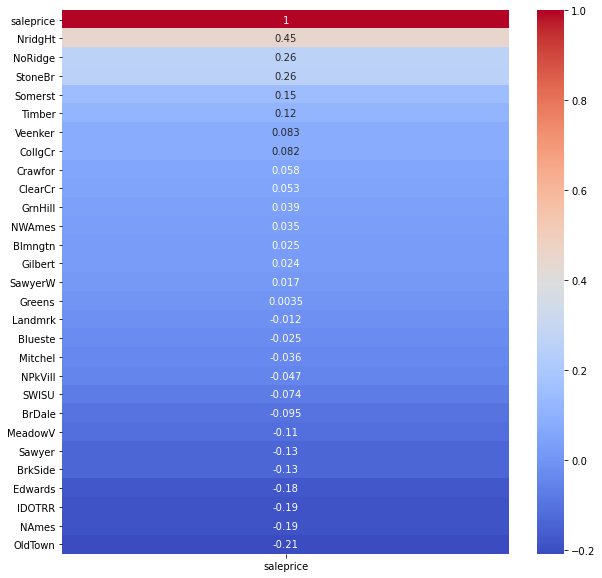

In [21]:
dumheat = pd.get_dummies(iowatrain['neighborhood']) #BUCKET THE HOOD
dumheat['saleprice'] = iowatrain['saleprice']

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(dumheat.corr()[['saleprice']].sort_values(by='saleprice', ascending=False),
           annot = True, cmap='coolwarm')

# sns.heatmap(iowatrain.corr()[['saleprice']].sort_values(by='saleprice', ascending=False),
#             annot=True, vmin=-1, vmax=1,
#            cmap='coolwarm', ax=ax);

In [22]:
dumheat.corr()[['saleprice']].sort_values(by='saleprice', ascending=False);
#NEIGHBORHOOD BUCKET

In [23]:
nicehood = ('NridgHt','NoRidge','StoneBr','Somerst',
    'Timber','Veenker','CollgCr','Crawfor','ClearCr')
okhood = ('Crawfor','ClearCr','GrnHill','NWAmes',
          'Blmngtn','Gilbert','SawyerW','Greens',
          'Landmrk','Blueste','Mitchel','NPkVill')	
badhood = ('SWISU','BrDale','MeadowV','Sawyer','BrkSide',
           'Edwards','IDOTRR','NAmes','OldTown')
# 

In [24]:
nicehood_cor =[]
okhood_cor = []
badhood_cor = []
for col in dumheat.columns:
    if col != 'saleprice':
        if dumheat[col].corr(dumheat['saleprice']) > 0.05:
            nicehood_cor.append(dumheat[col].corr(dumheat['saleprice']))
        elif dumheat[col].corr(dumheat['saleprice']) < -0.05:
            badhood_cor.append(dumheat[col].corr(dumheat['saleprice']))
        else:
            okhood_cor.append(dumheat[col].corr(dumheat['saleprice']))

print(
    np.mean(nicehood_cor),
    np.mean(okhood_cor),
    np.mean(badhood_cor))


0.16798675372099836 0.002234183929346371 -0.14585244112872237


In [25]:
[iowatrain['neighborhood'].replace(to_replace=col, value = 3, inplace=True) 
 for col in iowatrain['neighborhood'] if col in nicehood]

[iowatrain['neighborhood'].replace(to_replace=col, value = 2, inplace=True) 
 for col in iowatrain['neighborhood'] if col in okhood]

[iowatrain['neighborhood'].replace(to_replace=col, value = 1, inplace=True) 
 for col in iowatrain['neighborhood'] if col in badhood]
iowatrain['neighborhood']

### I just made this a bucketed list (more organized than dummies)

0       1
1       2
2       1
3       3
4       2
       ..
2046    3
2047    1
2048    3
2049    1
2050    2
Name: neighborhood, Length: 2051, dtype: int64

In [26]:
# # Now I should go through and change the Nominal Values to be Dummy and   
# # make sure the Nominal values are not numerical unless dummied. 
# nominal = [ 'ms_subclass', 'ms_zoning', 'street', 'alley', 'land_contour', 'lot_config', 
#            'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style',
#            'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
#            'foundation', 'heating', 'central_air', 'garage_type', 'misc_feature', 'sale_type' ]


    Let's do the bucket method with the Exterior_1 and Sale Type as well, as they both also have a lot of variables of multiple ranges from negative to positive and they look pretty significant so they may be worth including in the model. 

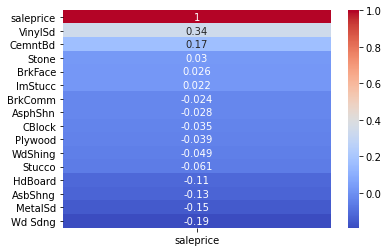

In [27]:
dumheat = pd.get_dummies(iowatrain['exterior_1st']) #Bucket the Exterior_1
dumheat['saleprice'] = iowatrain['saleprice']

sns.heatmap(dumheat.corr()[['saleprice']].sort_values(by='saleprice', ascending=False),
           annot = True, cmap='coolwarm');

In [28]:
good_ext = ('VinylSd','CemntBd')
ok_etr = ('Stone', 'BrkFace','ImStucc','BrkComm','PreCast',
          'AsphShn','CBlock','Plywood','WdShing','Stucco')
bad_ext = ('HdBoard', 'AsbShng', 'MetalSd','Wd Sdng')


In [29]:
[iowatrain['exterior_1st'].replace(to_replace=col, value = 3, inplace=True) 
 for col in iowatrain['exterior_1st'] if col in good_ext]

[iowatrain['exterior_1st'].replace(to_replace=col, value = 2, inplace=True) 
 for col in iowatrain['exterior_1st'] if col in ok_etr]

[iowatrain['exterior_1st'].replace(to_replace=col, value = 1, inplace=True) 
 for col in iowatrain['exterior_1st'] if col in bad_ext]
# WE JUST MADE ANOTHER BUCKET! 
iowatrain['exterior_1st'];

In [30]:
dumheat = pd.get_dummies(iowatrain['sale_type']) # Bucket the sale Type
dumheat['saleprice'] = iowatrain['saleprice']
dumheat.corr()[['saleprice']].sort_values(by='saleprice', ascending=False)
# Sale Type

,saleprice
saleprice,1.000000
New,0.358102
Con,0.033660
ConLI,0.019588
CWD,0.004563
Oth,-0.030109
ConLw,-0.035479
ConLD,-0.060431
COD,-0.107600
WD,-0.212542


In [31]:
garagemap = iowatrain['sale_type'].map( 
    {'WD ' : 1, 'New':3,'COD':1,'NA':2,'ConLD':2,'CWD':2, 'ConLI':2,'ConLw':2,'Oth':2,'Con' :2 })
iowatrain['sale_type']= garagemap
iowatrain['sale_type']

0       1
1       1
2       1
3       1
4       1
       ..
2046    1
2047    1
2048    1
2049    1
2050    1
Name: sale_type, Length: 2051, dtype: int64

## Dummify who?

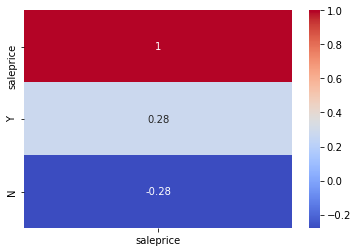

In [32]:
dumheat = pd.get_dummies(iowatrain['central_air']) #Dummy of importance
dumheat['saleprice'] = iowatrain['saleprice']

sns.heatmap(dumheat.corr()[['saleprice']].sort_values(by='saleprice', ascending=False),
           annot = True, cmap='coolwarm');

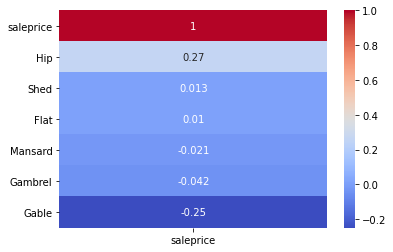

In [33]:
dumheat = pd.get_dummies(iowatrain['roof_style'])  #Dummy of importance
dumheat['saleprice'] = iowatrain['saleprice']

sns.heatmap(dumheat.corr()[['saleprice']].sort_values(by='saleprice', ascending=False),
           annot = True, cmap='coolwarm');

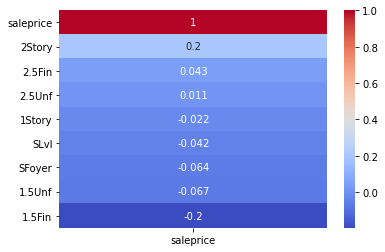

In [34]:
dumheat = pd.get_dummies(iowatrain['house_style'])  #Dummy of importance
dumheat['saleprice'] = iowatrain['saleprice']

sns.heatmap(dumheat.corr()[['saleprice']].sort_values(by='saleprice', ascending=False),
           annot = True, cmap='coolwarm');

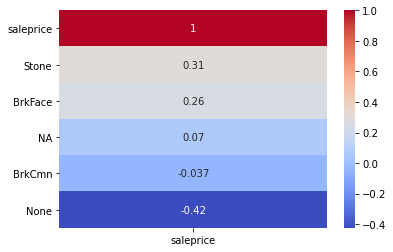

In [35]:
dumheat = pd.get_dummies(iowatrain['mas_vnr_type'])  #Dummy of importance
dumheat['saleprice'] = iowatrain['saleprice']

sns.heatmap(dumheat.corr()[['saleprice']].sort_values(by='saleprice', ascending=False),
           annot = True, cmap='coolwarm');

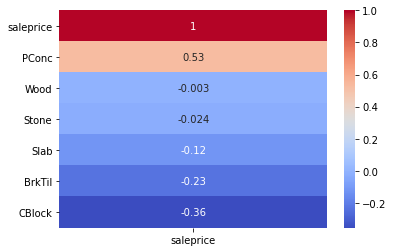

In [36]:
dumheat = pd.get_dummies(iowatrain['foundation'])  #Dummy of importance
dumheat['saleprice'] = iowatrain['saleprice']

sns.heatmap(dumheat.corr()[['saleprice']].sort_values(by='saleprice', ascending=False),
           annot = True, cmap='coolwarm');

 |'central_air'| 'house_style'| 'roof_style'|
|'mas_vnr_type'|'foundation'|

In [37]:
#Items to dummify because they actually kinda matter! # DUMMIES!!!!
pleasedummifyme = ('central_air', 'house_style', 'roof_style',
                   'foundation', 'mas_vnr_type')

In [38]:
dummified_dflist = [pd.get_dummies(iowatrain[i]) for i in iowatrain.columns 
                    if i in pleasedummifyme ]
dummified_dflist = pd.concat(dummified_dflist,axis = 1)


    Okay cool , so we have the dummified columns and we have fixed all the ordinal as well as make 3 buckets. 

    We still need to check the numerical columns and select the largest influencers, then we must also check for outliars. 

    Then we will make a DF with all the columns we care about. 

    Let's combine gr_liv_area with bs_sq_ft minus the unfinished basment area. This will give us the total living area and that seems to be of most importance. 
    (Credit to Alyssia Oh for having this brilliant idea)

In [39]:
iowatrain['tot_liv_area'] = iowatrain['gr_liv_area'] + iowatrain['total_bsmt_sf'] - iowatrain['bsmt_unf_sf']

In [40]:
iowatrain.corr()[['saleprice']].sort_values(by='saleprice', ascending=False).head(40)

,saleprice
saleprice,1.000000
overall_qual,0.800207
tot_liv_area,0.716558
exter_qual,0.712146
gr_liv_area,0.697038
kitchen_qual,0.692336
garage_area,0.650246
neighborhood,0.648311
garage_cars,0.648197
total_bsmt_sf,0.628668


DATA COLUMNS I AM INCLUDING IN MY TEST ! TAKING OFF THE REDUNDANT ONES.

    # 'overall_qual'	0.800207 Discrete
    # tot_liv_area	    0.763165
    # 'exter_qual'	    0.712146 Discrete
    # 'gr_liv_area'  	0.697038 REDUNDANT WITH TOTAL LIVING AREA
    # 'kitchen_qual'	0.692336 Discrete
    # 'garage_area'	    0.650246
    # 'neighborhood'	0.648311 THIS IS MY BUCKET!!
    # 'garage_cars' 	0.648197 Discrete / REDUNDANT W GARAGE AREA
    # 'total_bsmt_sf'	0.628668 REDUNDANT WITH TOTAL LIVING AREA
    # '1st_flr_sf'  	0.618486 REDUNDANT WITH TOTAL LIVING AREA
    # 'bsmt_qual'   	0.612188 Discrete
    # 'year_built'  	0.571849 Discrete / REDUNDANT W YEAR_REMODEL
    # 'garage_finish'	0.557839 Discrete / Redudant w garage_area
    # 'year_remod/add'	0.550370 Discrete
    # 'fireplace_qu'	0.538925 Discrete
    # 'full_bath'   	0.537969 Discrete
    # 'garage_yr_blt'	0.516738 Discrete / Redudant w garage_area
    # 'mas_vnr_area'	0.508602          / Redudant w mas_vnr_type
    # 'totrms_abvgrd'	0.504014 Discrete
    # 'fireplaces'  	0.471093 Disctete / Redudant wi fire_qual
    # 'heating_qc'  	0.458354 Discrete

    # ['central_air', 'house_style', 'roof_style', 'mas_vnr_type','foundation'] 
#dummies


    # ['sale_type', 'exterior_1st', 'neighborhood'] 
#buckets

## Remove Outliers

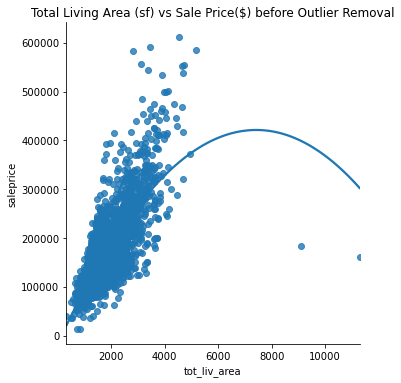

In [41]:
sns.lmplot(x = 'tot_liv_area', y = 'saleprice', data = iowatrain, ci = False, order = 2);
plt.title('Total Living Area (sf) vs Sale Price($) before Outlier Removal');

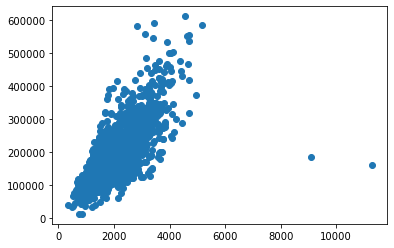

In [42]:
plt.scatter(x=iowatrain['tot_liv_area'], y=iowatrain['saleprice']);

  remove outliners over 5000! gr_liv_area, total_bsmt_sf.
  
remove outliners over 3500! 1st_flr_sf

In [43]:
for i in iowatrain.index:
    if iowatrain['gr_liv_area'][i]>5000:
        print(i)

960
1885


In [44]:
for i in iowatrain.index:
    if iowatrain['total_bsmt_sf'][i]>5000:
        print(i)

960
1885


In [45]:
for i in iowatrain.index:
    if iowatrain['1st_flr_sf'][i]>3500:
        print(i)

616
960
1885


In [46]:
iowatrain = iowatrain.drop(index= [616,960,1885], axis = 0)
iowatrain.reset_index()
dummified_dflist = dummified_dflist.drop(index= [616,960,1885], axis = 0)
dummified_dflist.reset_index()

,index,1.5Fin,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl,Flat,...,None,Stone,BrkTil,CBlock,PConc,Slab,Stone,Wood,N,Y
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,3,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4,4,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2046,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2044,2047,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
2045,2048,1,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
2046,2049,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1


    lets see how the total squarefootage graph has improved without outliars. 

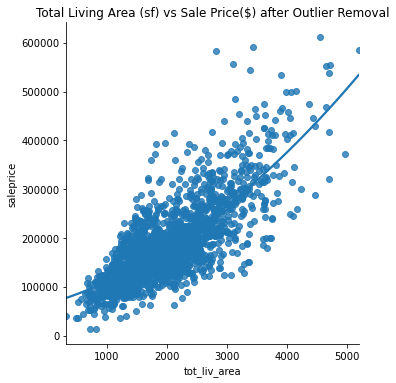

In [47]:
sns.lmplot(x = 'tot_liv_area', y = 'saleprice', data = iowatrain, ci = False, order = 2);
plt.title('Total Living Area (sf) vs Sale Price($) after Outlier Removal');

In [48]:
includedcolumns = ['overall_qual','tot_liv_area','exter_qual', 'kitchen_qual',
                   'garage_area', 'bsmt_qual','year_remod/add',
                   'fireplace_qu', 'full_bath', 'totrms_abvgrd','heating_qc',
                   'sale_type', 'exterior_1st', 'neighborhood'] 
#Removed the redudant ones and made sure to include the buckets! 

# ['central_air', 'house_style', 'roof_style', 'mas_vnr_type','foundation'] 
# Are the dummies. Don't worry we will include them as well. 


In [49]:
iowatrain_clean = iowatrain[includedcolumns]
iowatrain_clean.shape

(2048, 14)

In [50]:
dummified_dflist.shape

(2048, 27)

In [51]:
iowatrain.shape

(2048, 81)

In [52]:
iowatrain_clean = pd.concat([iowatrain_clean, dummified_dflist],axis=1, join='outer')
iowatrain_full = pd.concat([iowatrain, dummified_dflist],axis=1, join='outer')

In [53]:
iowatrain_clean.to_csv('./datasets/iowatrain_clean.csv')
iowatrain_full.to_csv('./datasets/iowatrain_full_clean.csv')

In [55]:

iowatrain_clean

,overall_qual,tot_liv_area,exter_qual,kitchen_qual,garage_area,bsmt_qual,year_remod/add,fireplace_qu,full_bath,totrms_abvgrd,...,None,Stone,BrkTil,CBlock,PConc,Slab,Stone,Wood,N,Y
0,6,2012.0,4,4,475.0,3,2005,0,2,6,...,0,0,0,1,0,0,0,0,0,1
1,7,2759.0,4,4,559.0,4,1997,3,2,8,...,0,0,0,0,1,0,0,0,0,1
2,5,1788.0,3,4,246.0,3,2007,0,1,5,...,1,0,0,1,0,0,0,0,0,1
3,5,1444.0,3,3,400.0,4,2007,0,2,7,...,1,0,0,0,1,0,0,0,0,1
4,6,1445.0,3,3,484.0,2,1993,0,2,6,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,8,2739.0,4,4,520.0,4,2007,4,2,7,...,1,0,0,0,1,0,0,0,0,1
2047,4,1123.0,3,3,539.0,3,1950,0,1,4,...,1,0,0,1,0,0,0,0,0,1
2048,6,1913.0,3,3,342.0,3,1950,3,1,9,...,1,0,1,0,0,0,0,0,0,1
2049,4,2105.0,3,3,294.0,3,1956,4,1,6,...,1,0,0,1,0,0,0,0,0,1


## After the outliners removed 

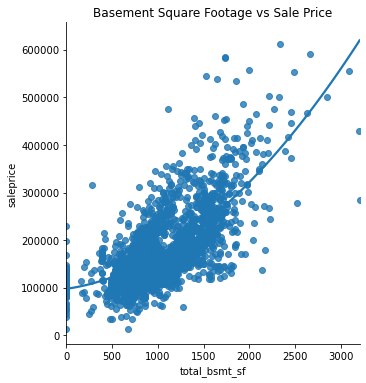

In [49]:
sns.lmplot(x = 'total_bsmt_sf', y = 'saleprice', data = iowatrain_full, ci = False, order = 2);
plt.title('Basement Square Footage vs Sale Price');

## Baseline Simple Model

    LETS DO A SIMPLE SIMPLE MODEL AS A BASELINE TO COMPARE. ALSO I"M CURIOUS, HOW GOOD A MODEL CAN BE IF WE JUST USE THE 5 HIGHEST CORRELATED VARIABLES IN A LINEAR REGRESSION MODEL. 

In [133]:
includedcolumns

['overall_qual',
 'tot_liv_area',
 'exter_qual',
 'kitchen_qual',
 'garage_area',
 'bsmt_qual',
 'year_remod/add',
 'fireplace_qu',
 'full_bath',
 'totrms_abvgrd',
 'heating_qc',
 'sale_type',
 'exterior_1st',
 'neighborhood']

In [139]:
lr = LinearRegression()
sc = StandardScaler()
features = ['overall_qual','tot_liv_area','exter_qual','kitchen_qual', 'garage_area']
X = iowatrain_clean[features]
y = iowatrain_full['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, random_state =42)
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

lr.fit(Z_train, y_train)

lr.score(Z_train, y_train)

0.8455201985733172

In [140]:
lr.score(Z_test, y_test)

0.8326510171649426

Our baseline model only including the top 5 correlated items in the data set actually give a relativly high score of 83.2% accuracy on our split test. 

## Make a Working Model

In [57]:
# Let's do this model

X = iowatrain_clean

y = iowatrain['saleprice']
X.shape

(2048, 41)

In [58]:
# lr = LinearRegression()
sc = StandardScaler()
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False )
X_overfit = poly.fit_transform(X)

In [59]:
sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X_overfit
                                                    , y, test_size=0.2, random_state=42)
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [60]:
# https://www.statology.org/ridge-regression-in-python/#:~:text=%20Ridge%20Regression%20in%20Python%20%28Step-by-Step%29%20%201,to%20Make%20Predictions.%20Lastly%2C%20we%20can...%20More%20
# I got the model idea from here, I tried a bit of different models.

#Defining the cross-validation to evaluate model
cv = RepeatedKFold(n_splits =10, n_repeats = 3, random_state = 42)
#defining model
model = RidgeCV(alphas=range(0,15,1), cv=cv)
#fit model
model.fit(Z_train, y_train)
#display lambda that produced the lowest test r2 score. optimal alpha.
print(model.alpha_)

14


In [61]:
print(model.score(Z_train, y_train))
print(model.score(Z_test, y_test))

0.9360051058299448
0.8764313085221062


    Below were some failed attempts at other models below. I tried a few others but they are lost in the scrap notebooks.

In [62]:
# knn_params = {
#     'n_neighbors': range(1,51,10),
#     'metric':['euclidean', 'manhattan']
# }

# knn_gridsearch = GridSearchCV(KNeighborsClassifier(),
#                              knn_params,
#                              cv=5,
#                              verbose=1)

# knn_gridsearch.fit(Z_train, y_train)

# knn_gridsearch.best_score_

# knn_gridsearch.score(Z_test, y_test)



# Instantiate.
# ridge_model = Ridge(alpha=10)

# # Fit.
# ridge_model.fit(Z_train, y_train)

# # Evaluate model using R2.
# print(ridge_model.score(Z_train, y_train))
# print(ridge_model.score(Z_test, y_test))

# print(Z_train.shape)
# print(Z_test.shape)

# lr.fit(Z_train, y_train)
# lr.score(Z_test, y_test)
# lr.score(Z_train, y_train)



In [63]:
#################################################################################################################################

### Now we shall use the model on our Test Data

In [92]:
iowatest = pd.read_csv('./datasets/test.csv')

In [93]:
iowatest.isnull().sum()

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    160
               ... 
Misc Feature    837
Misc Val          0
Mo Sold           0
Yr Sold           0
Sale Type         0
Length: 80, dtype: int64

In [94]:
iowatest["Bsmt Cond"].fillna('NA', inplace=True)
iowatest['Bsmt Qual'].fillna('NA', inplace=True)
iowatest['Bsmt Exposure'].fillna('NA', inplace=True)
iowatest['BsmtFin Type 1'].fillna('NA', inplace=True)
iowatest['BsmtFin Type 2'].fillna('NA', inplace=True)
iowatest['Electrical'].fillna(0, inplace=True)
iowatest['Fireplace Qu'].fillna('NA', inplace=True)
iowatest['Garage Finish'].fillna('NA', inplace=True)
iowatest['Garage Qual'].fillna('NA', inplace=True)
iowatest['Garage Cond'].fillna('NA', inplace=True)
iowatest['Pool QC'].fillna('NA', inplace=True)
iowatest['Fence'].fillna('NA', inplace=True)

iowatest.columns = [x.lower() for x in iowatest.columns]
iowatest.columns = [x.strip().replace(' ', '_') for x in iowatest.columns]

iowatest['ms_subclass'] = iowatest['ms_subclass'].astype(str)

iowatest.replace({
            'lot_shape': {'Reg':4 , 'IR1':3 , 'IR2':2 , 'IR3':1 },
            'utilities': {'AllPub':3, 'NoSeWa':2, 'NoSewr':1 },
            'land_slope': {'Gtl':3,  'Mod':2, 'Sev':1},
            'exter_qual': {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'exter_cond': {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'bsmt_qual':  {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'bsmt_cond':  {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'bsmt_exposure': {'NA': 0, 'Gd':4 , 'Av':3, 'Mn':2, 'No':1},
            'bsmtfin_type_1': {'NA':0, 'GLQ':6, 'ALQ':5, 'BLQ':4,
                                      'Rec':3, 'LwQ':2, 'Unf':1},
            'bsmtfin_type_2': {'NA':0, 'GLQ':6, 'ALQ':5, 'BLQ':4,
                                      'Rec':3, 'LwQ':2, 'Unf':1},
            'heating_qc': {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'electrical': {'SBrkr':5, 'FuseA':4, 'FuseF':3, 'FuseP':2, 'Mix':1},
            'kitchen_qual':  {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'functional':{'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5, 
                                   'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':1 },
            'fireplace_qu': {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'garage_finish': {'NA':0, 'Fin':3, 'RFn':2, 'Unf':1},
            'garage_qual':   {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'garage_cond':    {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'paved_drive':   {'Y':3, 'P':2, 'N':1},
            'pool_qc':   {'NA':0, 'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1},
            'fence':  {'NA':0, 'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1}
            }, inplace=True)

In [95]:
iowatest

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,4,Lvl,...,0,0,0,0,0,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,3,Lvl,...,0,0,0,0,0,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,3,Lvl,...,0,0,0,0,0,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,4,Lvl,...,0,0,0,0,0,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,3,Lvl,...,0,185,0,0,0,NaN,0,7,2009,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,1662,527377110,60,RL,80.0,8000,Pave,NaN,4,Lvl,...,0,0,0,0,0,NaN,0,11,2007,WD
874,1234,535126140,60,RL,90.0,14670,Pave,NaN,4,Lvl,...,0,0,0,0,3,NaN,0,8,2008,WD
875,1373,904100040,20,RL,55.0,8250,Pave,NaN,4,Lvl,...,0,0,0,0,0,NaN,0,8,2008,WD
876,1672,527425140,20,RL,60.0,9000,Pave,NaN,4,Lvl,...,0,0,0,0,2,NaN,0,5,2007,WD


In [96]:
#BUCKET THE HOOD
[iowatest['neighborhood'].replace(to_replace=col, value = 3, inplace=True) 
 for col in iowatest['neighborhood'] if col in nicehood]

[iowatest['neighborhood'].replace(to_replace=col, value = 2, inplace=True) 
 for col in iowatest['neighborhood'] if col in okhood]

[iowatest['neighborhood'].replace(to_replace=col, value = 1, inplace=True) 
 for col in iowatest['neighborhood'] if col in badhood]

# BUCKET THE EXTERIOR
[iowatest['exterior_1st'].replace(to_replace=col, value = 3, inplace=True) 
 for col in iowatest['exterior_1st'] if col in good_ext]

[iowatest['exterior_1st'].replace(to_replace=col, value = 2, inplace=True) 
 for col in iowatest['exterior_1st'] if col in ok_etr]

[iowatest['exterior_1st'].replace(to_replace=col, value = 1, inplace=True) 
 for col in iowatest['exterior_1st'] if col in bad_ext]

#BUCKET THE SALE TYPE
iowatest['sale_type'] = iowatest['sale_type'].map( 
    {'WD ' : 1, 'WD' : 1, 'New':3,'COD':1,'NA':2,'ConLD':2,
     'CWD':2, 'ConLI':2,'ConLw':2,'Oth':2,'Con' :2, 'VWD':2 })


In [97]:
# WE JUST MADE ANOTHER BUCKET! hoods
iowatest['neighborhood'].value_counts()

1    395
3    299
2    184
Name: neighborhood, dtype: int64

In [98]:
# WE JUST MADE ANOTHER BUCKET! ext-1
iowatest['exterior_1st'].value_counts()

1    416
3    337
2    125
Name: exterior_1st, dtype: int64

In [100]:
# WE JUST MADE ANOTHER BUCKET! SALE TYPE
iowatest['sale_type'].value_counts()

1    779
3     78
2     21
Name: sale_type, dtype: int64

    Now we dummify.

In [102]:
dummified_TEST = [pd.get_dummies(iowatest[i]) for i in iowatest.columns 
                    if i in pleasedummifyme ]
dummified_TEST = pd.concat(dummified_TEST,axis = 1)

    can't forget our new column total living area

In [104]:
iowatest['tot_liv_area'] = iowatest['gr_liv_area'] + iowatest['total_bsmt_sf'] - iowatest['bsmt_unf_sf']

     Now to get the columns we are interested in! 

In [105]:
iowatest_clean = iowatest[includedcolumns]
iowatest_clean.shape

(878, 14)

In [106]:
dummified_TEST.shape

(878, 27)

In [107]:
iowatest_clean = pd.concat([iowatest_clean, dummified_TEST],
                          axis=1, join='outer')

In [111]:
iowatest_clean.shape

(878, 41)

In [110]:
X.shape

(2048, 41)

     HELL YEA OUR MATRICIES MATCH! I have a good feeling

In [112]:
XX = iowatest_clean

In [113]:
XX_poly = poly.transform(XX)

In [114]:
ZZ_test = sc.transform(XX_poly)

In [115]:
model.predict(ZZ_test);

In [116]:
np.any(np.isnan(XX))


False

In [117]:
iowatest['saleprice'] = model.predict(ZZ_test)

In [118]:
submission = iowatest[['id', 'saleprice']].copy()

In [119]:
submission

,id,saleprice
0,2658,143362.243889
1,2718,146780.738401
2,2414,206189.071828
3,1989,108074.049537
4,625,173647.834750
...,...,...
873,1662,200994.981163
874,1234,199849.213151
875,1373,136599.910523
876,1672,115901.030985


In [121]:
submission.to_csv('./datasets/submission_00.csv', index=False)

## Conclusions and Recommendations

We can say with confidence that the overall quality, total living area , exterior quality, kitchen area and garage area have significant impacts on the price of the house. Going from 5 variables to 19 variables and using a more rubust model we only gained 4.3% accuracy. 

I would like to dig further into methods of fitting and tranforming the data. I'd like to see if we analyze more what columns can should be included and what models could increase the accuracy without overfitting the data. 